In [21]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.backend import clear_session

import numpy as np
import matplotlib.pyplot as plt
from transformer import TransformerBlock, TokenAndPositionEmbedding

In [3]:
!if ! ls /tmp/FOX_train.h5; \
    wget https://repo.gorchilov.net/datasets/fox-multi-factor.tar.gz -O /tmp/fox.tar.gz; \
    tar -xf /tmp/fox.tar.gz -C /tmp; \
    end

import h5py

train = h5py.File('/tmp/FOX_train.h5', mode='r')
test = h5py.File('/tmp/FOX_test.h5', mode='r')

/tmp/FOX_train.h5


In [4]:
X_train = train['data'][:]
y_train = train['labels'][:]

X_test = test['data'][:]
y_test = test['labels'][:]

In [22]:
transposed = np.array([x.T for x in X_train])

In [78]:
sample_size = 10000

embed_dim = 4
num_heads = 4 # Number of attention heads
ff_dim = 128 # Hidden layer size in feed forward network inside transformer

clear_session()

inputs = Input(shape=(1000, 4))
# inputs = Input(shape=(1000,))

# embedding_layer = TokenAndPositionEmbedding(1000, sample_size, 4)
# x = embedding_layer(inputs)
x = inputs

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
# x = Dropout(0.1)(x)
outputs = Dense(31, activation='relu')(x)

model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 4)]         0         
_________________________________________________________________
transformer_block (Transform (None, 1000, 4)           1252      
_________________________________________________________________
global_average_pooling1d (Gl (None, 4)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_7 (Dense)              (None, 31)                3999      
Total params: 5,891
Trainable params: 5,891
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.compile(optimizer=Adam(), loss='mae')
history = model.fit(
    transposed[:10000], y_train[:10000], epochs=10
)

Epoch 1/10
313/313 [==============================] - 17s 53ms/step - loss: 158.0006
Epoch 2/10
313/313 [==============================] - 16s 52ms/step - loss: 158.0002
Epoch 3/10
313/313 [==============================] - 16s 52ms/step - loss: 158.0002
Epoch 4/10
313/313 [==============================] - 16s 52ms/step - loss: 158.0001
Epoch 5/10
313/313 [==============================] - 16s 52ms/step - loss: 158.0001
Epoch 6/10
313/313 [==============================] - 16s 52ms/step - loss: 158.0002
Epoch 7/10
313/313 [==============================] - 16s 52ms/step - loss: 158.0001
Epoch 8/10
313/313 [==============================] - 16s 52ms/step - loss: 158.0002
Epoch 9/10
313/313 [==============================] - 16s 52ms/step - loss: 158.0002
Epoch 10/10
313/313 [==============================] - 17s 53ms/step - loss: 158.0002


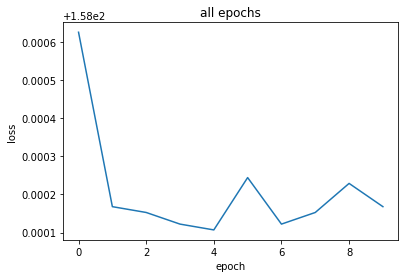

In [80]:
start = 0
end = 10

plt.title('all epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(start, end), history.history['loss'][start:end])
plt.show()

In [74]:
model.evaluate(np.array([x.T for x in X_test]), y_test)

313/313 [==============================] - 6s 20ms/step - loss: 65154772.0000


65154772.0

In [75]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [81]:
pred = model.predict(np.expand_dims(X_test[1].T, 0))

print(pred)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]]


In [13]:
model.save('model_saves/transformer-model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_saves/transformer-model/assets
